<a href="https://colab.research.google.com/github/pierreduke/ET4245_AI_and_Application/blob/main/Rice_Leaf_Diseases_using_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive._mount('/content/drive')

Mounted at /content/drive


In [2]:
!unzip /content/drive/MyDrive/ImgProc/rice_disease.zip

Archive:  /content/drive/MyDrive/ImgProc/rice_disease.zip
   creating: rice_disease/
   creating: rice_disease/test/
   creating: rice_disease/test/Bacterial leaf blight/
  inflating: rice_disease/test/Bacterial leaf blight/DSC_0374.JPG  
  inflating: rice_disease/test/Bacterial leaf blight/DSC_0378.JPG  
  inflating: rice_disease/test/Bacterial leaf blight/DSC_0379.JPG  
  inflating: rice_disease/test/Bacterial leaf blight/DSC_0380.JPG  
  inflating: rice_disease/test/Bacterial leaf blight/DSC_0388.JPG  
  inflating: rice_disease/test/Bacterial leaf blight/DSC_0390.JPG  
  inflating: rice_disease/test/Bacterial leaf blight/DSC_0392.JPG  
  inflating: rice_disease/test/Bacterial leaf blight/DSC_0393.JPG  
  inflating: rice_disease/test/Bacterial leaf blight/DSC_0395.JPG  
  inflating: rice_disease/test/Bacterial leaf blight/DSC_0404.JPG  
  inflating: rice_disease/test/Bacterial leaf blight/DSC_0405.JPG  
  inflating: rice_disease/test/Bacterial leaf blight/DSC_0700.jpg  
  inflating: 

**1) Khai báo thư viện**

In [3]:
#Khai bao thu vien
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam
from keras.utils import np_utils
from keras.layers.core import Dropout
from imutils import paths
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPool2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.models import Sequential
from google.colab.patches import cv2_imshow
from keras.models import load_model
import matplotlib.pyplot as plt
import numpy as np
import pickle
import cv2
import os
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


**2) Khởi tạo model**

In [4]:
model = Sequential()
model.add(Conv2D(input_shape=(224, 224, 3), filters=64, kernel_size=(3, 3),
                 padding='same', activation='relu'))
model.add(Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2), strides=(2, 2)))

model.add(Conv2D(filters=128, kernel_size=(3,3), padding='same', activation='relu'))
model.add(Conv2D(filters=128, kernel_size=(3,3), padding='same', activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2), strides=(2, 2)))

model.add(Conv2D(filters=256, kernel_size=(3,3), padding='same', activation='relu'))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding='same', activation='relu'))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding='same', activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2), strides=(2, 2)))

model.add(Conv2D(filters=512, kernel_size=(3,3), padding='same', activation='relu'))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding='same', activation='relu'))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding='same', activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2), strides=(2, 2)))

model.add(Conv2D(filters=512, kernel_size=(3,3), padding='same', activation='relu'))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding='same', activation='relu'))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding='same', activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2), strides=(2, 2)))

model.add(Flatten())

model.add(Dense(units = 512, activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(units = 256, activation = 'relu'))

model.add(Dense(units=3, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 64)      1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 224, 224, 64)      36928     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 64)     0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 112, 112, 128)     73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 112, 112, 128)     147584    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 128)      0         
 2D)                                                    

**3) Thiết lập LR, Batch_size, Epochs**

In [5]:
#thiet lap thong so lr, batch_size va epochs
INIT_LR = 1e-5
BS = 8
EPOCHS = 50

**4) Khởi tạo ảnh đầu vào**

In [6]:
#khoi tao input
imagePaths = list(paths.list_images('/content/rice_disease/train'))
data = []
labels = []

for imagePath in imagePaths:
    label = imagePath.split(os.path.sep)[-2]
    image = cv2.imread(imagePath)
    image = cv2.resize(image, (224,224))
    data.append(image)
    labels.append(label)
data = np.array(data, dtype="float") / 255.0

In [7]:
#khoi tao input
imagePaths_val = list(paths.list_images('/content/rice_disease/val'))
data_val = []
labels_val = []

for imagePath_val in imagePaths_val:
    label_val = imagePath_val.split(os.path.sep)[-2]
    image_val = cv2.imread(imagePath_val)
    image_val = cv2.resize(image_val, (224,224))
    data_val.append(image_val)
    labels_val.append(label_val)
data_val = np.array(data_val, dtype="float") / 255.0

**5) Mã hoá one-hot nhãn**

In [8]:
#one-hot label
le = LabelEncoder()
labels = le.fit_transform(labels)
labels = np_utils.to_categorical(labels, 3)
labels_val = le.fit_transform(labels_val)
labels_val = np_utils.to_categorical(labels_val, 3)

**6) Thiết lập dữ liệu train**

In [9]:
X_train = data
y_train = labels
X_val = data_val
y_val = labels_val

In [10]:
checkpoint_filepath = '/content/drive/MyDrive/model_checkpoint/'
print('Creating Directory: ' + checkpoint_filepath)
os.makedirs(checkpoint_filepath, exist_ok=True)

Creating Directory: /content/drive/MyDrive/model_checkpoint/


In [11]:
custom_callbacks = [
    EarlyStopping(
        monitor = 'val_loss',
        mode = 'min',
        patience = 5,
        verbose = 1
    ),
    ModelCheckpoint(
        filepath = os.path.join(checkpoint_filepath, 'Rice_Leaf_Diseases.h5'),
        monitor = 'val_loss',
        mode = 'min',
        verbose = 1,
        save_best_only = True
    )
]

**7) Compile và train model**

In [12]:
#compile + train
opt = Adam(learning_rate=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])
H = model.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=BS,
              steps_per_epoch=len(X_train) // BS, epochs=EPOCHS, callbacks = custom_callbacks)

Epoch 1/50
81/81 [==============================] - ETA: 0s - loss: 1.0988 - accuracy: 0.3179
Epoch 00001: val_loss improved from inf to 1.09750, saving model to /content/drive/MyDrive/model_checkpoint/Rice_Leaf_Diseases.h5
81/81 [==============================] - 45s 383ms/step - loss: 1.0988 - accuracy: 0.3179 - val_loss: 1.0975 - val_accuracy: 0.3354
Epoch 2/50
81/81 [==============================] - ETA: 0s - loss: 1.0840 - accuracy: 0.4408
Epoch 00002: val_loss improved from 1.09750 to 0.97368, saving model to /content/drive/MyDrive/model_checkpoint/Rice_Leaf_Diseases.h5
81/81 [==============================] - 34s 387ms/step - loss: 1.0840 - accuracy: 0.4408 - val_loss: 0.9737 - val_accuracy: 0.5244
Epoch 3/50
81/81 [==============================] - ETA: 0s - loss: 0.9610 - accuracy: 0.5156
Epoch 00003: val_loss improved from 0.97368 to 0.81160, saving model to /content/drive/MyDrive/model_checkpoint/Rice_Leaf_Diseases.h5
81/81 [==============================] - 31s 387ms/step 

**8) Đồ thị**

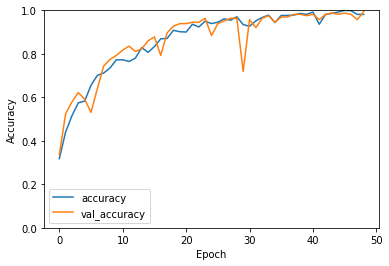

In [16]:
#do thi
import matplotlib.pyplot as plt

plt.plot(np.arange(0, 49), H.history['accuracy'], label = 'accuracy')
plt.plot(np.arange(0, 49), H.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend()
plt.show()

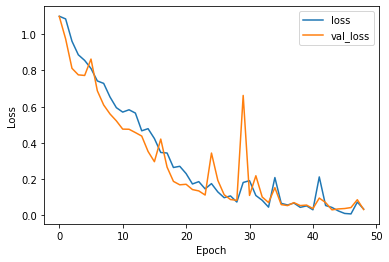

In [17]:
#do thi
import matplotlib.pyplot as plt

plt.plot(np.arange(0, 49), H.history['loss'], label='loss')
plt.plot(np.arange(0, 49), H.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

**Đánh giá**

---



---



In [18]:
from keras.models import load_model

model1 = load_model('/content/drive/MyDrive/model_checkpoint/Rice_Leaf_Diseases.h5')

In [19]:
score_train = model.evaluate(X_train, y_train)
print('Score train = ', score_train)

21/21 [==============================] - 18s 401ms/step - loss: 0.0057 - accuracy: 1.0000
Score train =  [0.005676961503922939, 1.0]


**6) Bảng thống kê các giá trị phân loại**


> Accuracy = (TP+TN)/(TP+FP+FN+TN)

> Precision = TP/(TP+FP)

> Recall = TP/(TP+FN)

> F1 Score = 2(Recall * Precision) / (Recall + Precision)

















In [20]:
y_pred_train = model.predict(X_train)
from sklearn.metrics import classification_report
print(classification_report(y_train.argmax(axis=1), y_pred_train.argmax(axis=1), target_names=le.classes_, digits = 6))

                       precision    recall  f1-score   support

Bacterial leaf blight   1.000000  1.000000  1.000000       218
           Brown spot   1.000000  1.000000  1.000000       218
            Leaf smut   1.000000  1.000000  1.000000       214

             accuracy                       1.000000       650
            macro avg   1.000000  1.000000  1.000000       650
         weighted avg   1.000000  1.000000  1.000000       650



In [21]:
trainY = np.argmax(y_train, axis=1).ravel()
predtrainY = np.argmax(y_pred_train, axis=1).ravel()
from sklearn.metrics import confusion_matrix
cnf_matrix = confusion_matrix(trainY, predtrainY)
print(cnf_matrix)

[[218   0   0]
 [  0 218   0]
 [  0   0 214]]


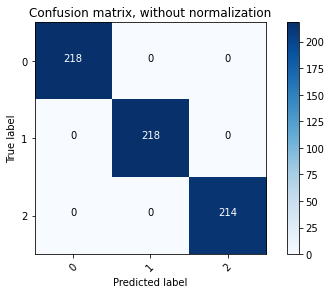

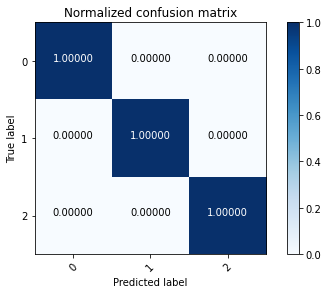

In [22]:
import matplotlib.pyplot as plt
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1, keepdims = True)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.5f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Plot non-normalized confusion matrix
class_names = [0, 1, 2]
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

In [23]:
#khoi tao input
imagePaths_test = list(paths.list_images('/content/rice_disease/test'))
data_test = []
labels_test = []

for imagePath_test in imagePaths_test:
    label_test = imagePath_test.split(os.path.sep)[-2]
    image_test = cv2.imread(imagePath_test)
    image_test = cv2.resize(image_test, (224,224))
    data_test.append(image_test)
    labels_test.append(label_test)
data_test = np.array(data_test, dtype="float") / 255.0
#one-hot label
le_test = LabelEncoder()
labels_test = le_test.fit_transform(labels_test)
labels_test = np_utils.to_categorical(labels_test, 3)

In [24]:
X_test = data_test
y_test = labels_test

In [25]:
score_test = model.evaluate(X_test, y_test)
print('Score test = ', score_test)

2/2 [==============================] - 5s 5s/step - loss: 3.2591 - accuracy: 0.7111
Score test =  [3.2590692043304443, 0.7111111283302307]


In [26]:
y_pred_test = model.predict(X_test)
from sklearn.metrics import classification_report
print(classification_report(y_test.argmax(axis=1), y_pred_test.argmax(axis=1), target_names=le.classes_, digits = 6))

                       precision    recall  f1-score   support

Bacterial leaf blight   0.916667  0.733333  0.814815        15
           Brown spot   0.642857  0.600000  0.620690        15
            Leaf smut   0.631579  0.800000  0.705882        15

             accuracy                       0.711111        45
            macro avg   0.730368  0.711111  0.713796        45
         weighted avg   0.730368  0.711111  0.713796        45



In [27]:
testY = np.argmax(y_test, axis=1).ravel()
predtestY = np.argmax(y_pred_test, axis=1).ravel()
from sklearn.metrics import confusion_matrix
cnf_matrix = confusion_matrix(testY, predtestY)
print(cnf_matrix)

[[11  2  2]
 [ 1  9  5]
 [ 0  3 12]]


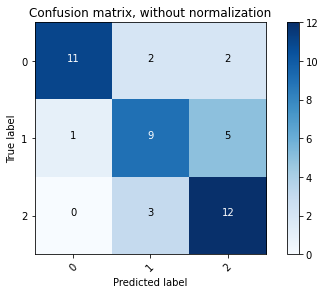

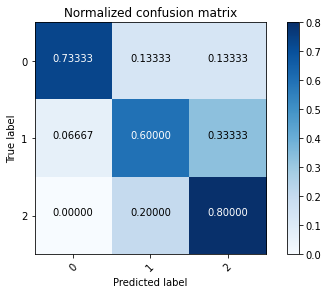

In [28]:
import matplotlib.pyplot as plt
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1, keepdims = True)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.5f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Plot non-normalized confusion matrix
class_names = [0, 1, 2]
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

In [29]:
def define_label(x):
  if x == 0:
    return 'Loại bệnh: Bacterial Leaf Blight'
  if x == 1:
    return 'Loại bệnh: Brown spot'
  if x == 2:
    return 'Loại bệnh: Leaf smut'

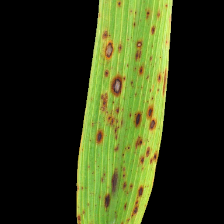

[[1.8064640e-11 9.9999964e-01 3.2149393e-07]]
1
Loại bệnh: Brown spot


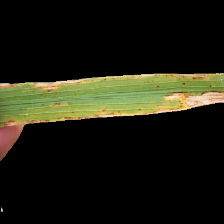

[[1.0000000e+00 3.4099426e-16 6.6677412e-16]]
0
Loại bệnh: Bacterial Leaf Blight


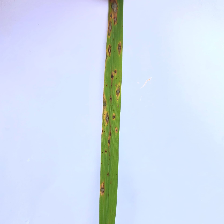

[[0.00508466 0.5697312  0.42518416]]
1
Loại bệnh: Brown spot


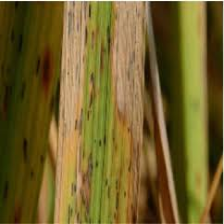

[[5.8297837e-18 1.0000000e+00 1.7455801e-15]]
1
Loại bệnh: Brown spot


In [30]:
import glob
folder = glob.glob('/content/drive/MyDrive/external/*.*')
for file in folder:
  img = cv2.imread(file)
  img = cv2.resize(img,(224,224))
  cv2_imshow(img)
  img = img.reshape(1,224,224,3)
  data_leaf = np.array(img, dtype = 'float') /255.0
  one = model.predict(data_leaf)
  print(one)
  x = np.argmax(one)
  print(x)
  print(define_label(x))